# DL - HM02.3
# question 3_ code 4

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

Training with alpha=0.1, beta=0.1
Val Accuracy: 0.4292, Recon Loss: 1.0154, Class Loss: 1.6073

Training with alpha=0.1, beta=0.5
Val Accuracy: 0.4412, Recon Loss: 1.2258, Class Loss: 1.5693

Training with alpha=0.1, beta=1.0
Val Accuracy: 0.4096, Recon Loss: 1.4175, Class Loss: 1.6436

Training with alpha=0.1, beta=2.0
Val Accuracy: 0.4084, Recon Loss: 1.3228, Class Loss: 1.6670

Training with alpha=0.5, beta=0.1
Val Accuracy: 0.4316, Recon Loss: 0.9910, Class Loss: 1.5786

Training with alpha=0.5, beta=0.5
Val Accuracy: 0.4530, Recon Loss: 1.0377, Class Loss: 1.5453

Training with alpha=0.5, beta=1.0
Val Accuracy: 0.4414, Recon Loss: 1.0413, Class Loss: 1.5957

Training with alpha=0.5, beta=2.0
Val Accuracy: 0.4336, Recon Loss: 1.2302, Class Loss: 1.5812

Training with alpha=1.0, beta=0.1
Val Accuracy: 0.4702, Recon Loss: 0.8089, Class Loss: 1.4910

Training with alpha=1.0, beta=0.5
Val Accuracy: 0.4652, Recon Loss: 0.8743, Class 

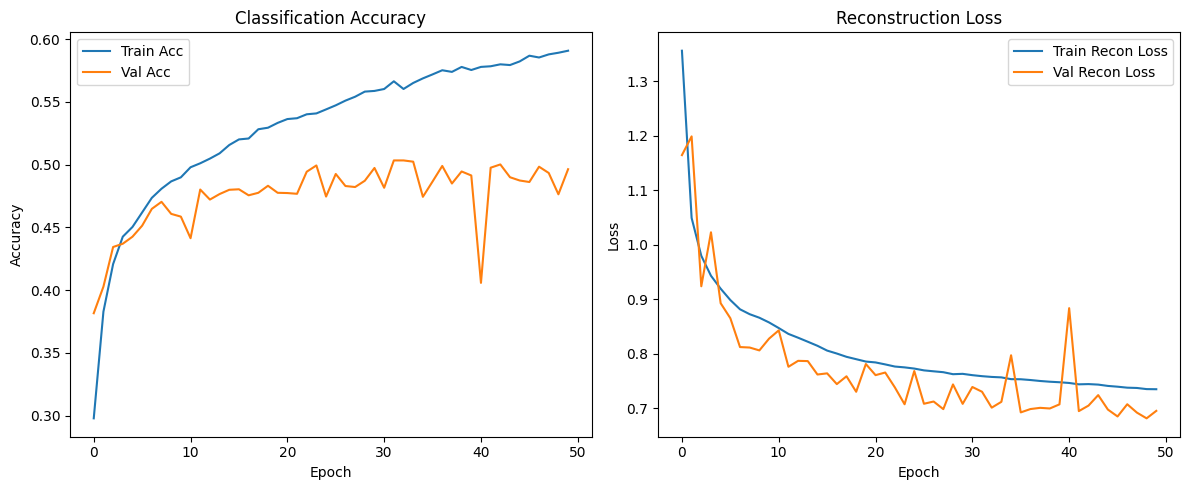

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


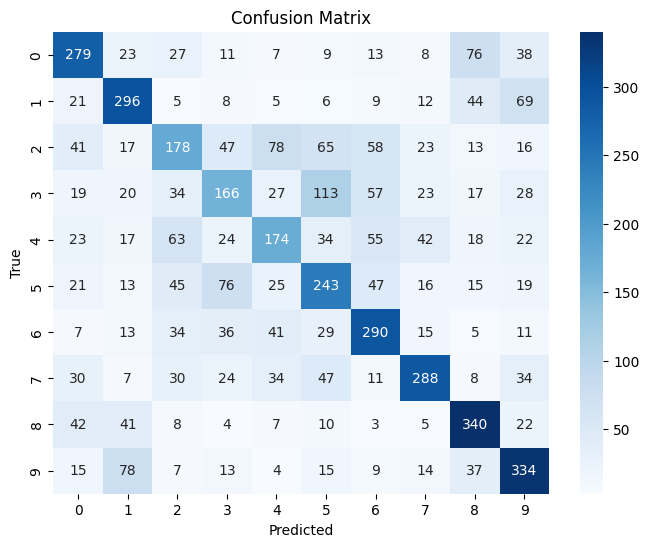

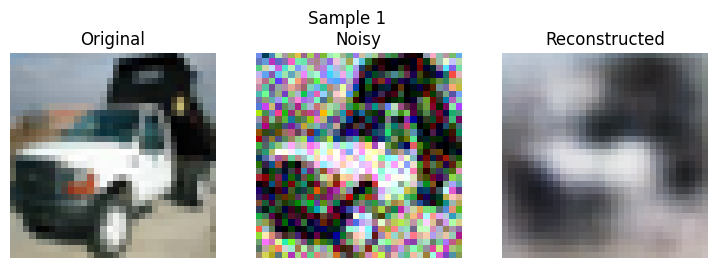

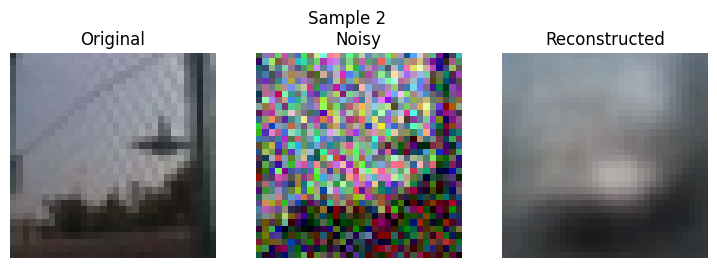

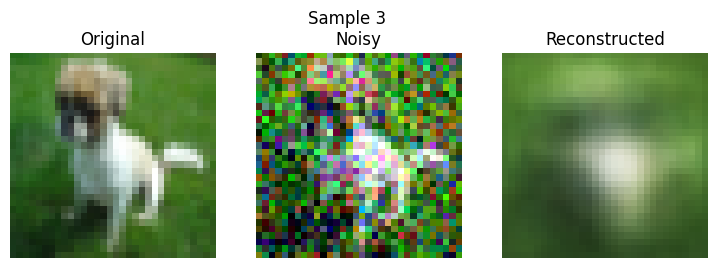

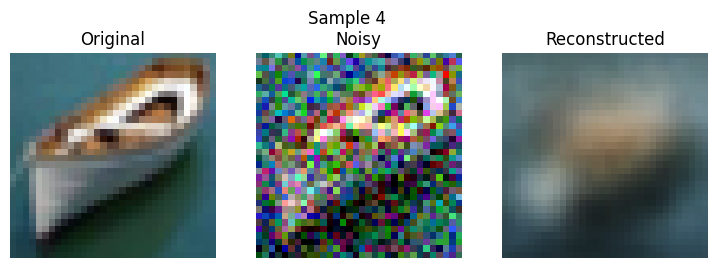

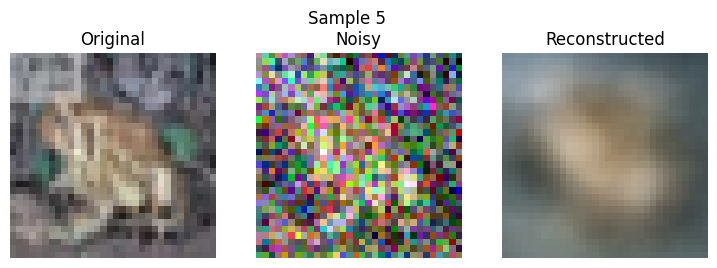

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# === 1. Load & preprocess CIFAR-10 ===
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize and flatten
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape(-1, 32*32*3)
x_test = x_test.reshape(-1, 32*32*3)
y_train = y_train.flatten()
y_test = y_test.flatten()

# Split into train, val, test (80/10/10)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(
    x_val, y_val, test_size=0.5, random_state=42)

# Add Gaussian noise
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_val_noisy = x_val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# === 2. Custom scaled loss functions ===
def scaled_mse(scale):
    def loss_fn(y_true, y_pred):
        return tf.reduce_mean(tf.square(y_true - y_pred)) / scale
    return loss_fn

def scaled_ce(scale):
    def loss_fn(y_true, y_pred):
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return tf.reduce_mean(ce) / scale
    return loss_fn


# === 3. Build Model ===
def build_multitask_model(input_dim=3072, latent_dim=256):
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    encoded = layers.Dense(latent_dim, activation='relu')(x)

    # Decoder (Denoising)
    x_dec = layers.Dense(512, activation='relu')(encoded)
    x_dec = layers.BatchNormalization()(x_dec)
    x_dec = layers.Dropout(0.2)(x_dec)
    x_dec = layers.Dense(1024, activation='relu')(x_dec)
    x_dec = layers.BatchNormalization()(x_dec)
    decoded = layers.Dense(input_dim, activation='sigmoid', name='reconstruction')(x_dec)

    # Classification Head
    x_class = layers.Dense(128, activation='relu')(encoded)
    x_class = layers.BatchNormalization()(x_class)
    x_class = layers.Dropout(0.3)(x_class)
    class_output = layers.Dense(10, activation='softmax', name='classification')(x_class)

    model = models.Model(inputs=inputs, outputs=[decoded, class_output])
    return model
# === 4. Broadcasting Loss Weights ===
# تعریف محدوده ضرایب

alpha_values = [0.1, 0.5, 1.0, 2.0]  # وزن وظیفه بازسازی
beta_values = [0.1, 0.5, 1.0, 2.0]   # وزن وظیفه طبقه‌بندی

recon_scale = 0.02  # میانگین تقریبی MSE اولیه
class_scale = 1.0   # میانگین تقریبی CrossEntropy اولیه

best_val_acc = 0.0
best_alpha = None
best_beta = None
results = []

for alpha in alpha_values:
    for beta in beta_values:
        print(f"\nTraining with alpha={alpha}, beta={beta}")

        # ساخت و کامپایل مدل
        model = build_multitask_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss={
                'reconstruction': scaled_mse(recon_scale),
                'classification': scaled_ce(class_scale),
            },
            loss_weights={
                'reconstruction': alpha,
                'classification': beta,
            },
            metrics={'classification': 'accuracy'}
        )

        # آموزش مدل
        history = model.fit(
            x=x_train_noisy,
            y={'reconstruction': x_train, 'classification': y_train},
            epochs=10,  # تعداد epoch کمتر برای سرعت بیشتر در جستجو
            batch_size=128,
            validation_data=(x_val_noisy, {'reconstruction': x_val, 'classification': y_val}),
            verbose=0  # کاهش خروجی برای خوانایی
        )

        # ارزیابی روی داده اعتبارسنجی
        val_loss, val_recon_loss, val_class_loss, val_acc = model.evaluate(
            x_val_noisy,
            {'reconstruction': x_val, 'classification': y_val},
            verbose=0
        )

        results.append({
            'alpha': alpha,
            'beta': beta,
            'val_acc': val_acc,
            'val_recon_loss': val_recon_loss,
            'val_class_loss': val_class_loss
        })

        print(f"Val Accuracy: {val_acc:.4f}, Recon Loss: {val_recon_loss:.4f}, Class Loss: {val_class_loss:.4f}")

        # ذخیره بهترین مدل
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_alpha = alpha
            best_beta = beta

# نمایش نتایج
print("\n=== Best Configuration ===")
print(f"Best Alpha: {best_alpha}, Best Beta: {best_beta}, Best Val Accuracy: {best_val_acc:.4f}")

# === 5. Train Final Model with Best Weights ===
model = build_multitask_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        'reconstruction': scaled_mse(recon_scale),
        'classification': scaled_ce(class_scale),
    },
    loss_weights={
        'reconstruction': best_alpha,
        'classification': best_beta,
    },
    metrics={'classification': 'accuracy'}
)

history = model.fit(
    x=x_train_noisy,
    y={'reconstruction': x_train, 'classification': y_train},
    epochs=50,
    batch_size=128,
    validation_data=(x_val_noisy, {'reconstruction': x_val, 'classification': y_val})
)
# === 6. Evaluation ===
test_loss, test_recon_loss, test_class_loss, test_acc = model.evaluate(
    x_test_noisy,
    {'reconstruction': x_test, 'classification': y_test}
)
print(f"\nTest Losses: Total={test_loss:.4f}, Recon={test_recon_loss:.4f}, Class={test_class_loss:.4f}, Accuracy={test_acc:.4f}")

# === 7. Plot Accuracy & Loss ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_accuracy'], label='Train Acc')
plt.plot(history.history['val_classification_accuracy'], label='Val Acc')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['reconstruction_loss'], label='Train Recon Loss')
plt.plot(history.history['val_reconstruction_loss'], label='Val Recon Loss')
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# پیش‌بینی و نمایش نتایج مشابه کد اصلی
y_pred_recon, y_pred_class = model.predict(x_test_noisy)
y_pred_labels = np.argmax(y_pred_class, axis=1)

cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

num_samples = 5
indices = np.random.choice(len(x_test), num_samples)
for i, idx in enumerate(indices):
    orig = x_test[idx].reshape(32, 32, 3)
    noisy = x_test_noisy[idx].reshape(32, 32, 3)
    recon = y_pred_recon[idx].reshape(32, 32, 3)

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(noisy)
    plt.title("Noisy")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis('off')
    plt.suptitle(f"Sample {i+1}")
    plt.show()

In [4]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 3072)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_96 (Dense)          │ (None, 1024)           │      3,146,752 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_80    │ (None, 1024)           │          4,096 │ dense_96[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_64 (Dropout)      │ (None, 1024)           │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_97 (Dense)          │ (None, 512)            │        524,800 │ dropout_64[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_81    │ (None, 512)            │          2,048 │ dense_97[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_65 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_98 (Dense)          │ (None, 256)            │        131,328 │ dropout_65[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_99 (Dense)          │ (None, 512)            │        131,584 │ dense_98[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_82    │ (None, 512)            │          2,048 │ dense_99[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_66 (Dropout)      │ (None, 512)            │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_101 (Dense)         │ (None, 128)            │         32,896 │ dense_98[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_100 (Dense)         │ (None, 1024)           │        525,312 │ dropout_66[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_84    │ (None, 128)            │            512 │ dense_101[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_83    │ (None, 1024)           │          4,096 │ dense_100[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_67 (Dropout)      │ (None, 128)            │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reconstruction (Dense

 Total params: 22,953,888 (87.56 MB)

 Trainable params: 7,649,162 (29.18 MB)

 Non-trainable params: 6,400 (25.00 KB)

 Optimizer params: 15,298,326 (58.36 MB)